Here we will try to use technic Augmentation of data with combination of transfer learning

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

resolution = (256, 256)

#predprocess data 
directory = 'datasets2'

train = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="training",

)

valid = image_dataset_from_directory(
    directory,
    labels = "inferred",
    label_mode = "int",
    class_names = None,
    color_mode = "rgb",
    batch_size = 32,
    image_size = resolution,
    seed = 100,
    crop_to_aspect_ratio = False,
    validation_split=0.1,
    subset="validation",

)


Found 685 files belonging to 8 classes.
Using 617 files for training.
Found 685 files belonging to 8 classes.
Using 68 files for validation.


In [2]:
# Prefetch images to memory, to make training faster

AUTOTUNE = tf.data.AUTOTUNE

train = train.prefetch(buffer_size=AUTOTUNE)



In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
])

In [4]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = resolution + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [5]:
# Keep the pre-trained weights, set this to true to retrain the whole model.
base_model.trainable = False

In [6]:
input_shape = tf.keras.Input(shape=(resolution[0],resolution[1], 3))
x = data_augmentation(input_shape)

## we want to get resolution of dataset imgs as was in pre-trained model
x =  tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

## preventing overfitiing
x = tf.keras.layers.Dropout(0.2)(x)

## this is layer is added because we want to our dataset classes == pretrained model outputs
outputs_shape = tf.keras.layers.Dense(8)(x)
model = tf.keras.Model(input_shape, outputs_shape)

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(), # lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
history = model.fit(train,
                    epochs=60,
                    validation_data=valid)

Epoch 1/60
20/20 [==============================] - 17s 689ms/step - loss: 2.1484 - accuracy: 0.2253 - val_loss: 1.6822 - val_accuracy: 0.3676
Epoch 2/60
20/20 [==============================] - 13s 676ms/step - loss: 1.6585 - accuracy: 0.4003 - val_loss: 1.4313 - val_accuracy: 0.5441
Epoch 3/60
20/20 [==============================] - 14s 678ms/step - loss: 1.4808 - accuracy: 0.4441 - val_loss: 1.3733 - val_accuracy: 0.5882
Epoch 4/60
20/20 [==============================] - 14s 672ms/step - loss: 1.3269 - accuracy: 0.5186 - val_loss: 1.3339 - val_accuracy: 0.5735
Epoch 5/60
20/20 [==============================] - 14s 700ms/step - loss: 1.2120 - accuracy: 0.5721 - val_loss: 1.2665 - val_accuracy: 0.6029
Epoch 6/60
20/20 [==============================] - 13s 672ms/step - loss: 1.1772 - accuracy: 0.5835 - val_loss: 1.2615 - val_accuracy: 0.6324
Epoch 7/60
20/20 [==============================] - 13s 663ms/step - loss: 1.1280 - accuracy: 0.6013 - val_loss: 1.2490 - val_accuracy: 0.6176

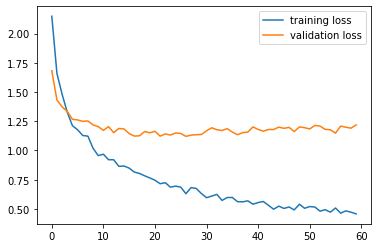

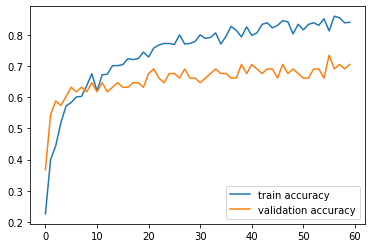

In [11]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

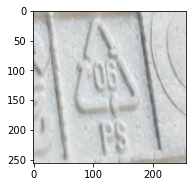

1/1 [==============================] - 0s 34ms/step
2 predicted


array([[-6.3203454 , -4.263617  , -0.01285034, -6.8743496 , -0.73443323,
        -1.1293774 , -5.205034  , -5.664991  ]], dtype=float32)

In [20]:
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_img(img_matrix):
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    
    ax1.imshow(img_matrix.astype('uint8'))

    plt.show()

def get_result(prediction):
    return np.argmax(prediction)

def procces_img(path):
    img_tmp = Image.open(path).resize((resolution[0],resolution[1]))
    return np.array(img_tmp).astype('uint8')




img = procces_img('test/6_1.jpg')
plot_img(img)
prediction = model.predict(img.reshape((-1, 256, 256, 3)))
print(f'{get_result(prediction)} predicted' )
prediction